In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import requests
import json
import datetime as dt

state_lockdown_file = pd.read_csv("data_sources/lockdown_us.csv")
state_deaths_cases_file = pd.read_csv("data_sources/liz-friedman-us-covid-19-data-from-nytimes/us-states.csv")
county_population_file = pd.read_csv("data_sources/qventus-covid-19-localized-scenario-planner/qventus-covid-19-localized-scenario-planner/covid_county_population_usafacts.csv")


In [2]:
url = "https://api.covidtracking.com/v1/states/current.json"
state_current_data = (requests.get(url)).json()
state_current_data=pd.DataFrame(state_current_data)
state_current_data.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200828,AK,5923,333615,NaN,37.0,NaN,NaN,NaN,8.0,...,339538,0,0,3d717bff28ffd8829334a2576c131afe5a550a1a,0,0,0,0,0,
1,20200828,AL,122185,842678,NaN,1002.0,14267.0,NaN,1450.0,NaN,...,964863,31,262,64b11813ba9a1d0f04a32f067a53266a0015df69,0,0,0,0,0,
2,20200828,AR,59583,638472,NaN,407.0,4142.0,NaN,NaN,95.0,...,698055,17,38,0cf9891af09ae849e96cfcd456206ac4ea85ace1,0,0,0,0,0,
3,20200828,AS,0,1514,NaN,NaN,NaN,NaN,NaN,NaN,...,1514,0,0,71cf54a1af4aaba2ea5be34e0d5bcd25b20bea4b,0,0,0,0,0,
4,20200828,AZ,200658,983419,NaN,809.0,21428.0,272.0,NaN,160.0,...,1184077,49,2,b6a4310291e6f2d45de519204f950abd7d77a207,0,0,0,0,0,


In [3]:
url = "https://api.covidtracking.com/v1/states/daily.json"
state_daily_data = (requests.get(url)).json()
state_daily_data=pd.DataFrame(state_daily_data)

#loop for summing for total state cases
states = state_daily_data["state"].unique()
total_cases_by_state = []


for state in states:
    state_case = state_daily_data.loc[state_daily_data["state"] == state]
    total_cases_by_state.append(state_case["positive"].sum())

In [4]:
#States total population
state_pop = []
states = county_population_file["State"].unique()

for state in states:
    state_df = county_population_file.loc[county_population_file["State"] == state]
    state_pop.append(state_df["population"].sum())
    
population_df = pd.DataFrame({
    "state": states,
    "population": state_pop
})

In [5]:
state_deaths_cases_file.head()
state_deaths_cases_file = state_deaths_cases_file.rename(columns={"state":"State"})
state_deaths_cases_file = state_deaths_cases_file.sort_values("State")

state_deaths_cases_file['month'] = pd.DatetimeIndex(state_deaths_cases_file['date']).month
state_deaths_cases_file['day'] = pd.DatetimeIndex(state_deaths_cases_file['date']).day

state_deaths_cases_file.head()

,date,State,fips,cases,deaths,month,day
2874,2020-04-24,Alabama,1,6026,209,4,24
7549,2020-07-18,Alabama,1,65234,1286,7,18
3589,2020-05-07,Alabama,1,9046,369,5,7
3699,2020-05-09,Alabama,1,9668,390,5,9
9254,2020-08-18,Alabama,1,110361,1936,8,18


In [6]:
state_deaths_cases_file = state_deaths_cases_file.dropna()
state_deaths_cases_file = state_deaths_cases_file.set_index("State")
state_deaths_cases_file.head()

,date,fips,cases,deaths,month,day
State,,,,,,
Alabama,2020-04-24,1,6026,209,4,24
Alabama,2020-07-18,1,65234,1286,7,18
Alabama,2020-05-07,1,9046,369,5,7
Alabama,2020-05-09,1,9668,390,5,9
Alabama,2020-08-18,1,110361,1936,8,18


In [7]:
first_state_deaths_cases_file = state_deaths_cases_file.loc[["Arizona","Florida","Kansas",
                                                       "New York","Washington","Wisconsin"],["date","deaths"]]

In [29]:
positive_closings = state_deaths_cases_file.loc[["California","Florida","New York", 
                                                "Kansas","Texas","Washington"],
                                                ["date","cases","month"]]
positive_closings = positive_closings.sort_values("date")
positive_closings.head()

,date,cases,month
State,,,
Washington,2020-01-21,1,1
Washington,2020-01-22,1,1
Washington,2020-01-23,1,1
Washington,2020-01-24,1,1
Washington,2020-01-25,1,1


In [54]:
california = positive_closings.loc["California"]
cali_closings = california.loc[(california["date"] >= "2020-03-19"),:]
cali_closings = california.loc[(california["date"] <= "2020-05-12"),:]
cali_closings = cali_closings.groupby(by=["month"]).agg(sum)

kansas = positive_closings.loc["Kansas"]
ks_closings = kansas.loc[(kansas["date"]>= "2020-04-19"),:]
ks_closings = kansas.loc[(kansas["date"]<= "2020-05-03"),:]
ks_closings = ks_closings.groupby(by=["month"]).agg(sum)

florida = positive_closings.loc["Florida"]
fl_closings = florida.loc[(florida["date"]>= "2020-04-03"),:]
fl_closings = florida.loc[(florida["date"]<= "2020-04-30"),:]
fl_closings = fl_closings.groupby(by=["month"]).agg(sum)

new_york = positive_closings.loc["New York"]
ny_closings = new_york.loc[(new_york["date"]>= "2020-03-22"),:]
ny_closings = new_york.loc[(new_york["date"]<= "2020-05-15"),:]
ny_closings = ny_closings.groupby(by=["month"]).agg(sum)

washington = positive_closings.loc["Washington"]
wa_closings = washington.loc[(washington["date"]>= "2020-03-23"),:]
wa_closings = washington.loc[(washington["date"]<= "2020-05-04"),:]
wa_closings = wa_closings.groupby(by=["month"]).agg(sum)

texas = positive_closings.loc["Texas"]
tx_closings = texas.loc[(texas["date"]>= "2020-04-02"),:]
tx_closings = texas.loc[(texas["date"]<= "2020-04-30"),:]
tx_closings = tx_closings.groupby(by=["month"]).agg(sum)

In [66]:
cali_reo = california.loc[(california["date"] >= "2020-05-12"),:]
cali_reo = cali_reo.groupby(by=["month"]).agg(sum)

ks_reo = kansas.loc[(kansas["date"]>= "2020-05-03"),:]
ks_reo = ks_reo.groupby(by=["month"]).agg(sum)

fl_reo = florida.loc[(florida["date"]>= "2020-04-30"),:]
fl_reo = fl_reo.groupby(by=["month"]).agg(sum)

ny_reo = new_york.loc[(new_york["date"]>= "2020-05-15"),:]
ny_reo = ny_reo.groupby(by=["month"]).agg(sum)

wa_reo = washington.loc[(washington["date"]>= "2020-05-04"),:]
wa_reo = wa_reo.groupby(by=["month"]).agg(sum)

tx_reo = texas.loc[(texas["date"]>= "2020-04-30"),:]
tx_reo = tx_reo.groupby(by=["month"]).agg(sum)

In [17]:
ks_data = first_state_deaths_cases_file.loc[["Kansas"],["date","deaths"]]
ks_data=ks_data.sort_values("deaths")

In [18]:
state_lockdown_file[pd.isnull(state_lockdown_file['County'])]
state_lockdown_file[pd.isnull(state_lockdown_file['Type'])]

state_lockdown_file['month'] = pd.DatetimeIndex(state_lockdown_file['Date']).month
state_lockdown_file['day'] = pd.DatetimeIndex(state_lockdown_file['Date']).day

state_lockdown_file

,Country,State,County,Date,Type,month,day
0,United States,Alabama,NaN,2020-04-04,Stay at home,4,4
1,United States,Alabama,Birmingham,2020-03-24,Shelter in place,3,24
2,United States,Alaska,NaN,2020-03-28,Stay at home,3,28
3,United States,Arizona,NaN,2020-03-31,Stay at home,3,31
4,United States,California,NaN,2020-03-19,Stay at home,3,19
...,...,...,...,...,...,...,...
168,United States,Virginia,NaN,2020-03-30,Stay at home,3,30
169,United States,Washington,NaN,2020-03-23,Stay at home,3,23
170,United States,West Virginia,NaN,2020-03-24,Stay at home,3,24
171,United States,Wisconsin,NaN,2020-03-25,Stay at home,3,25


In [19]:
state_current_narrow = state_current_data[["state","positive","death","hospitalized"]]
state_current_drop = state_current_narrow.dropna()
state_current_drop
state_current_drop = state_current_drop.set_index('state')
state_current_drop

state_current_df = pd.merge(state_current_drop, population_df, on='state')
state_current_df.head()

,state,positive,death,hospitalized,population
0,AL,122185,2107,14267.0,4903185
1,AR,59583,756,4142.0,3017804
2,AZ,200658,4978,21428.0,7278717
3,CO,56343,1835,6928.0,5758736
4,CT,52495,4465,11180.0,3565287


In [20]:
special_states_data = state_current_drop.loc[["AZ","FL","KS","NY","WA","WI"],["death","hospitalized"]]
special_states_data

,death,hospitalized
state,,
AZ,4978,21428.0
FL,11099,38474.0
KS,443,2278.0
NY,25312,89995.0
WA,1890,6674.0
WI,1121,5736.0


Text(0.5, 1.0, 'Comparing States by Deaths and Hospitalizations Due to COVID-19')

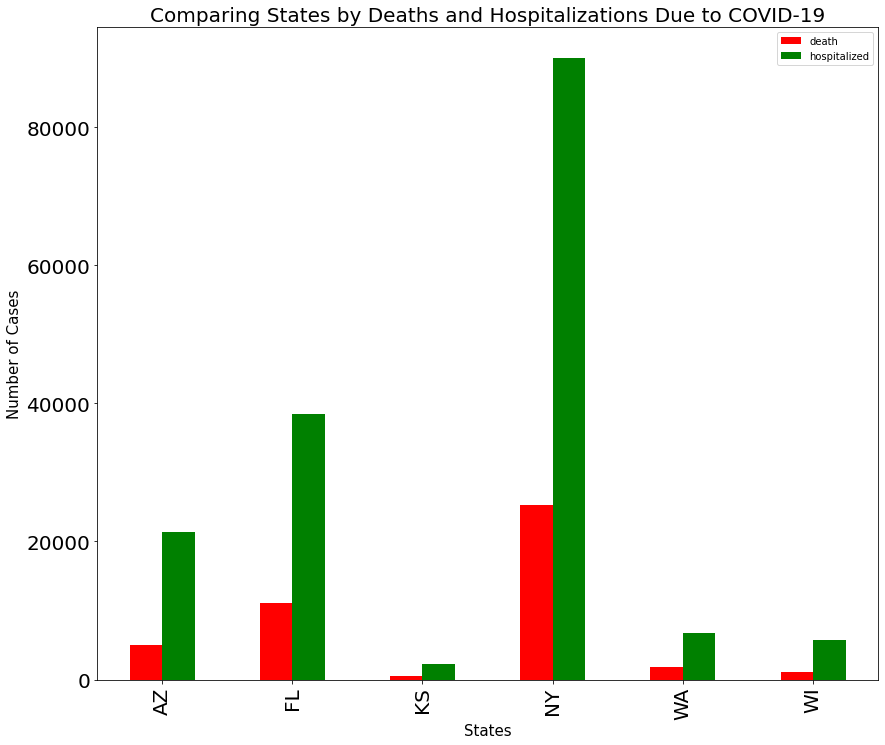

In [21]:
my_colors = "rgbkymc"
plot_pandas = special_states_data.plot.bar(figsize=(14,12),color= my_colors ,fontsize=20)
plt.xlabel("States", fontsize = 15)
plt.ylabel("Number of Cases", fontsize = 15)
plt.title("Comparing States by Deaths and Hospitalizations Due to COVID-19", fontsize=20)

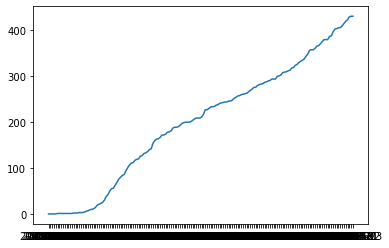

In [22]:
plt.plot(ks_data["date"],ks_data["deaths"])

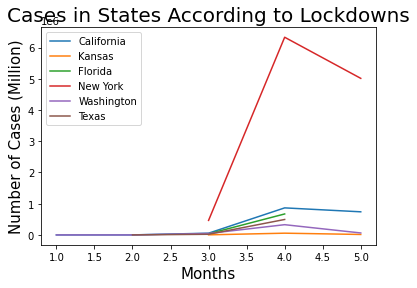

<Figure size 432x288 with 0 Axes>

In [72]:
cali_handle_1 = plt.plot(cali_closings, label="California")
ks_handle_1 = plt.plot(ks_closings, label="Kansas")
fl_handle_1 = plt.plot(fl_closings,label="Florida")
ny_handle_1 = plt.plot(ny_closings, label="New York")
wa_handle_1 = plt.plot(wa_closings, label="Washington")
tx_handle_1 = plt.plot(tx_closings, label="Texas")
#(handles=[cali_handle_1,ks_handle_1,fl_handle_1,ny_handle_1,wa_handle_1,tx_handle_1],loc="best")
plt.legend(loc="best")
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of Cases (Million)", fontsize=15)
plt.title("Cases in States According to Lockdowns", fontsize=20)
plt.show()
plt.tight_layout()

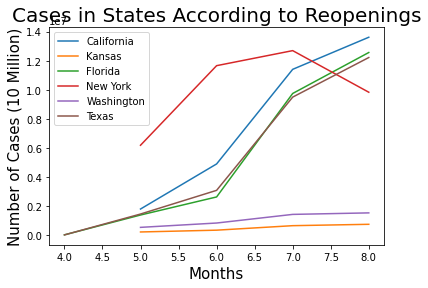

<Figure size 432x288 with 0 Axes>

In [71]:
cali_handle_2 = plt.plot(cali_reo, label="California")
ks_handle_2 = plt.plot(ks_reo, label="Kansas")
fl_handle_2 = plt.plot(fl_reo,label="Florida")
ny_handle_2 = plt.plot(ny_reo, label="New York")
wa_handle_2 = plt.plot(wa_reo, label="Washington")
tx_handle_2 = plt.plot(tx_reo, label="Texas")
plt.legend(loc="best")
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of Cases (10 Million)", fontsize=15)
plt.title("Cases in States According to Reopenings", fontsize=20)
plt.show()
plt.tight_layout()